## Краткое содержание

Статья про датасет: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4113415/


| Признаки | Модель | dev R^2 | test R^2 |
| --- | --- | --- | --- |
| - | const | 0 | 0 |
| 1-gram char | linear regression | 0.4097 | - |
| 2-gram char | linear regression | 0.4219 | - |
| 2-gram char + len | linear regression | 0.4324 | 0.4924 |
| 2-gram char + len | random forest | 0.8339 | - |
| 2-gram char + len | catboost | 0.8379 | 0.9444 |
| колонка "calc" | - | 0.8866 | 0.8812 |


Код отдельно не выносил, так как мне показалось, что он не слишком загромождает отчёт. 


Другие подходы не пробовал, так как random forest и catboost показали довольно-таки хорошие метрики и вряд ли найдутся модели получше, так как если взять колонку calc (вычисленные значения по формуле) в качестве предсказаний, то получаются аналогичные метрики. Ну и у меня времени было не так уж и много.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import catboost

from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.feature_extraction import text as sk_text

%matplotlib inline

## Данные

### Загружаем данные

In [2]:
!wget -O FreeSolv.csv https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/SAMPL.csv

--2022-02-18 05:29:16--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/SAMPL.csv
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 64:ff9b::34db:7461
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|64:ff9b::34db:7461|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32060 (31K) [text/csv]
Saving to: ‘FreeSolv.csv’

100%[======================================>] 32 060       160KB/s   in 0,2s   

2022-02-18 05:29:18 (160 KB/s) - ‘FreeSolv.csv’ saved [32060/32060]



### Смотрим на сырые данные

In [3]:
!head FreeSolv.csv

In [4]:
!wc -l FreeSolv.csv

643 FreeSolv.csv


In [5]:
!tail FreeSolv.csv

### Считываем данные и опять смотрим на них

In [6]:
df = pd.read_csv('FreeSolv.csv')

In [7]:
df.head()

,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917


In [8]:
df.shape

(642, 4)

In [9]:
df.describe(include='all')

,iupac,smiles,expt,calc
count,642,642,642.000000,642.000000
unique,642,642,NaN,NaN
top,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,NaN,NaN
freq,1,1,NaN,NaN
mean,NaN,NaN,-3.803006,-3.486223
std,NaN,NaN,3.847820,4.186301
min,NaN,NaN,-25.470000,-21.762000
25%,NaN,NaN,-5.727500,-5.421500
50%,NaN,NaN,-3.530000,-3.053500
75%,NaN,NaN,-1.215000,-0.480750


### Разбиваем на train/dev/test

In [10]:
train_dev_df, test_df = model_selection.train_test_split(df, test_size=0.1, random_state=42)

In [11]:
train_df, dev_df = model_selection.train_test_split(train_dev_df, test_size=1/9, random_state=42)

In [12]:
train_df.shape, dev_df.shape, test_df.shape

((512, 4), (65, 4), (65, 4))

In [13]:
train_df.head()

,iupac,smiles,expt,calc
286,methane,C,2.00,2.446
267,"(1R)-2,2,2-trichloro-1-dimethoxyphosphoryl-eth...",COP(=O)([C@H](C(Cl)(Cl)Cl)O)OC,-12.74,-13.424
362,"(2R,3R,4S,5S,6R)-6-(hydroxymethyl)tetrahydropy...",C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O,-25.47,-18.095
224,"methyl 2,2,2-trifluoroacetate",COC(=O)C(F)(F)F,-1.10,-1.353
318,"3,5,5-trimethylcyclohex-2-en-1-one",CC1=CC(=O)CC(C1)(C)C,-5.18,-4.088


In [14]:
dev_df.head()

,iupac,smiles,expt,calc
340,"1,2,3,4-tetrachlorobenzene",c1cc(c(c(c1Cl)Cl)Cl)Cl,-1.34,-0.304
53,"2,6-dimethoxyphenol",COc1cccc(c1O)OC,-6.96,-7.393
565,1-bromo-pentane,CCCCCBr,-0.10,0.824
557,naphthalen-2-amine,c1ccc2cc(ccc2c1)N,-7.47,-8.003
445,methoxymethane,COC,-1.91,-0.853


### Смотрим на распределение ответов в тренировочной выборке

(array([  1.,   1.,   4.,   3.,   5.,  40.,  90., 196., 119.,  53.]),
 array([-25.47, -22.58, -19.69, -16.8 , -13.91, -11.02,  -8.13,  -5.24,
         -2.35,   0.54,   3.43]),
 <BarContainer object of 10 artists>)

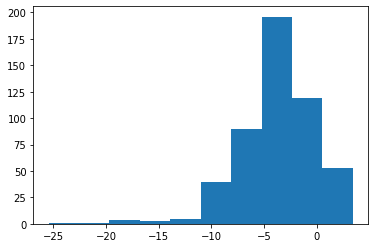

In [15]:
plt.hist(train_df.expt)

### Смотрим на распределение длин входных строк в тренировочной выборке

(array([149., 220.,  70.,  38.,  20.,   6.,   5.,   2.,   1.,   1.]),
 array([ 1. ,  9.1, 17.2, 25.3, 33.4, 41.5, 49.6, 57.7, 65.8, 73.9, 82. ]),
 <BarContainer object of 10 artists>)

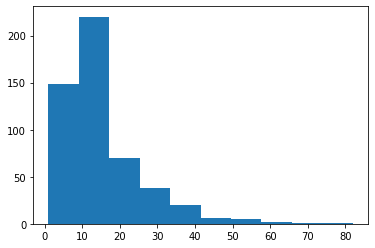

In [16]:
plt.hist(train_df.smiles.apply(lambda sm: len(sm)))

## Подсчёт метрик

### Настраиваем подсчёт метрик

Чтобы не переобучиться на тестовую выборку, будем считать по умолчанию метрики только для тренировочной и валидационной выборок.

In [17]:
def calc_metrics_on_set(model, split_df, prefix):
    preds = split_df.smiles.apply(model)
    targets = split_df.expt
    return {
        f'{prefix}-R2': metrics.r2_score(targets, preds),
        f'{prefix}-RMSE': metrics.mean_squared_error(targets, preds) ** 0.5
    }

def calc_metrics(model, include_test=False):
    ans = calc_metrics_on_set(model, train_df, 'train')
    ans.update(calc_metrics_on_set(model, dev_df, 'dev'))
    if include_test:
        ans.update(calc_metrics_on_set(model, test_df, 'test'))
    return ans

### Протестируем подсчёт метрик для константы -5 (взята из распределения ответов в тренировочной выборке)

In [18]:
calc_metrics(lambda x: -5)

{'train-R2': -0.10212040813115353,
 'train-RMSE': 3.947276577947446,
 'dev-R2': -0.10083154805353023,
 'dev-RMSE': 3.8892607563352226}

### Ещё протестируем подсчёт метрик для среднего значения ответа для тренирочной выборки

In [19]:
train_df.expt.mean()

-3.79845703125

In [20]:
calc_metrics(lambda x: train_df.expt.mean())

{'train-R2': 0.0,
 'train-RMSE': 3.7599583610806033,
 'dev-R2': -4.356265177341001e-05,
 'dev-RMSE': 3.706944528222653}

### Всё правдоподобно, для тренировочной выборки коэффициент детерминации должен быть равен нулю.

### Посмотрим для этой константы метрики на тестовой выборке, возьмём их в качестве бейзлайна.

In [21]:
calc_metrics(lambda x: train_df.expt.mean(), include_test=True)

{'train-R2': 0.0,
 'train-RMSE': 3.7599583610806033,
 'dev-R2': -4.356265177341001e-05,
 'dev-RMSE': 3.706944528222653,
 'test-R2': -2.0034199601282054e-05,
 'test-RMSE': 4.572485017769191}

### Заметим, что метрики (особенно $R^2$) на train/dev/test похожи, но полностью не совпадают

## Моделирование

### Смотрим данные внимательнее

In [22]:
train_df.head(n=50)

,iupac,smiles,expt,calc
286,methane,C,2.00,2.446
267,"(1R)-2,2,2-trichloro-1-dimethoxyphosphoryl-eth...",COP(=O)([C@H](C(Cl)(Cl)Cl)O)OC,-12.74,-13.424
362,"(2R,3R,4S,5S,6R)-6-(hydroxymethyl)tetrahydropy...",C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O,-25.47,-18.095
224,"methyl 2,2,2-trifluoroacetate",COC(=O)C(F)(F)F,-1.10,-1.353
318,"3,5,5-trimethylcyclohex-2-en-1-one",CC1=CC(=O)CC(C1)(C)C,-5.18,-4.088
331,"1,2-dimethoxybenzene",COc1ccccc1OC,-5.33,-4.055
617,"2,2,2-trifluoroethanol",C(C(F)(F)F)O,-4.31,-3.809
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
235,propane,CCC,2.00,2.495
431,"2,3,7,8-tetrachlorodibenzo-p-dioxin",c1c2c(cc(c1Cl)Cl)Oc3cc(c(cc3O2)Cl)Cl,-3.37,-2.540


### Ничего не понятно :)

### Попробуем мешок символов (по аналогии с мешком слов) в качестве признаков с линейной регрессией

#### Учим модель для извлечения признаков

In [23]:
to1gram = sk_text.CountVectorizer(analyzer='char', lowercase=False)

In [24]:
to1gram.fit(train_df.smiles)

CountVectorizer(analyzer='char', lowercase=False)

#### Проверяем её работу

In [25]:
train_df.smiles[0]

'CN(C)C(=O)c1ccc(cc1)OC'

In [26]:
to1gram.transform([train_df.smiles[0]]).toarray()

array([[0, 3, 3, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 1, 2, 0, 0,
        0, 0, 0, 6, 0, 0, 0, 0]])

#### Смотрим словарь символ -> индекс в векторе

In [27]:
to1gram.vocabulary_, len(to1gram.vocabulary_)

({'C': 14,
  'O': 19,
  'P': 20,
  '(': 1,
  '=': 11,
  ')': 2,
  '[': 22,
  '@': 12,
  'H': 16,
  ']': 24,
  'l': 26,
  '1': 6,
  'F': 15,
  'c': 25,
  'S': 21,
  '2': 7,
  '3': 8,
  'N': 18,
  'n': 27,
  'B': 13,
  'r': 28,
  'I': 17,
  '+': 3,
  '-': 4,
  '4': 9,
  's': 29,
  '/': 5,
  '#': 0,
  '5': 10,
  '\\': 23},
 30)

#### В примере CN(C)C(=O)c1ccc(cc1)OC решёток нет, то есть первый элемент вектора действительно должен быть равен нулю, символов 'c' шесть штук, то есть на 26-м месте как раз число 6

#### Готовим данные для обучения линейной регрессии

In [28]:
X_train = to1gram.transform(train_df.smiles)
y_train = train_df.expt

#### Учим модель линейной регрессии

In [29]:
lr = linear_model.ElasticNet()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.39199740712758413

#### Считаем метрики полученной модели

In [30]:
def model(smiles):
    vector = to1gram.transform([smiles])
    result = lr.predict(vector)
    return result

In [31]:
calc_metrics(model)

{'train-R2': 0.39199740712758413,
 'train-RMSE': 2.9318095227066885,
 'dev-R2': 0.4097112997644019,
 'dev-RMSE': 2.8479926405764164}

#### Сильно лучше константы: на валидационном множестве $R^2$ равен 0.4097 по сравнению с нулём для константы

### Пробуем в качестве признаков биграмы символов с линейной регрессией

Дальше действия аналогичные, не буду комментировать все шаги

In [32]:
to2gram = sk_text.CountVectorizer(analyzer='char', lowercase=False, ngram_range=(1, 2))
to2gram.fit(train_df.smiles)

CountVectorizer(analyzer='char', lowercase=False, ngram_range=(1, 2))

In [33]:
train_df.smiles[0]

'CN(C)C(=O)c1ccc(cc1)OC'

In [34]:
to2gram.transform([train_df.smiles[0]]).toarray()

array([[0, 0, 0, 3, 1, 1, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 6, 1, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]])

In [35]:
print(to2gram.vocabulary_)

{'C': 80, 'O': 117, 'P': 129, '(': 3, '=': 70, ')': 12, '[': 139, '@': 74, 'H': 105, ']': 146, 'l': 166, 'CO': 96, 'OP': 125, 'P(': 130, '(=': 4, '=O': 72, 'O)': 118, ')(': 13, '([': 9, '[C': 140, 'C@': 90, '@H': 76, 'H]': 106, '](': 147, '(C': 5, 'C(': 82, 'Cl': 101, 'l)': 167, ')C': 17, ')O': 21, 'OC': 124, '1': 35, '@@': 75, ']1': 149, '1[': 44, '(O': 8, 'O1': 121, '1)': 37, 'F': 103, '(F': 6, 'F)': 104, ')F': 18, 'CC': 92, 'C1': 85, '1=': 39, '=C': 71, 'C)': 83, 'c': 155, 'Oc': 128, 'c1': 158, '1c': 45, 'cc': 163, '1O': 43, 'S': 131, 'CS': 97, 'S(': 132, '2': 47, '3': 58, 'c2': 159, '2c': 56, 'c(': 156, '(c': 10, '1C': 41, 'c3': 160, '3c': 63, '3O': 61, 'O2': 122, '2)': 49, 'N': 109, 'CN': 95, 'N1': 113, 'C[': 98, 'NC': 115, 'n': 168, '=S': 73, 'S)': 133, '(n': 11, 'nc': 173, 'n1': 170, ')c': 25, '2C': 51, 'C=': 89, 'B': 78, 'r': 175, 'CB': 91, 'Br': 79, ')[': 23, 'cn': 164, 'Cc': 100, '1N': 42, 'Nc': 116, 'N(': 110, ')S': 22, 'SC': 134, '2N': 53, '1(': 36, '[n': 143, 'nH': 172, ']

In [36]:
X_train = to2gram.transform(train_df.smiles)
y_train = train_df.expt
lr = linear_model.ElasticNet()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.4232407964283962

In [37]:
def model(smiles):
    vector = to2gram.transform([smiles])
    result = lr.predict(vector)
    return result

In [38]:
calc_metrics(model)

{'train-R2': 0.4232407964283962,
 'train-RMSE': 2.8554877551613447,
 'dev-R2': 0.4219328254898328,
 'dev-RMSE': 2.8183555598330754}

#### Метрика R^2 на train и dev стала чуть лучше: 0.4232 и 0.4219 против 0.392 и 0.4097

#### Посмотрим, как коррелируют длина входной строки и ответ

In [39]:
train_df.corrwith(train_df.smiles.apply(lambda sm: len(sm)))

expt   -0.333146
calc   -0.368376
dtype: float64

#### Какая-то корреляция есть

### Давайте в признаки добавм длину строки и опять обучить линейную модель

In [40]:
X_train = np.hstack((
        np.array([train_df.smiles.apply(lambda sm: len(sm)).tolist()]).T,
        to2gram.transform(train_df.smiles).toarray()
    )
)
y_train = train_df.expt

In [41]:
X_train.shape

(512, 181)

In [42]:
X_train[:2]

array([[ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [30,  0,  0,  0,  5,  1,  3,  0,  0,  0,  1,  0,  0,  5,  2,  0,
         0,  0,  1,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,

In [43]:
train_df.iloc[:2]

,iupac,smiles,expt,calc
286,methane,C,2.00,2.446
267,"(1R)-2,2,2-trichloro-1-dimethoxyphosphoryl-eth...",COP(=O)([C@H](C(Cl)(Cl)Cl)O)OC,-12.74,-13.424


In [44]:
lr = linear_model.ElasticNet()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.4069589323277878

In [45]:
np.hstack(([[-1]], to1gram.transform([train_df.smiles[0]]).toarray() ))

array([[-1,  0,  3,  3,  0,  0,  0,  2,  0,  0,  0,  0,  1,  0,  0,  4,
         0,  0,  0,  1,  2,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0]])

In [46]:
def model(smiles):
    vector = np.hstack((
        [[len(smiles)]],
        to2gram.transform([smiles]).toarray()
    ))
    result = lr.predict(vector)
    return result

In [47]:
calc_metrics(model)

{'train-R2': 0.4069589323277878,
 'train-RMSE': 2.895512338699316,
 'dev-R2': 0.43242491946227657,
 'dev-RMSE': 2.7926614341952916}

#### На train метрики чуть ухудшились, на dev'е улучшились, давайте будем считать, что из рассмотренных трёх моделей эта самая лучшая

### И посчитаем её метрики на тестовой выборке

In [48]:
calc_metrics(model, include_test=True)

{'train-R2': 0.4069589323277878,
 'train-RMSE': 2.895512338699316,
 'dev-R2': 0.43242491946227657,
 'dev-RMSE': 2.7926614341952916,
 'test-R2': 0.4924357803323661,
 'test-RMSE': 3.2575676271796454}

### Веса модели

In [49]:
lr.coef_

array([-0.1001849 , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.05104382,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [50]:
lr.intercept_

-2.8602568607487084

### В целом получилось неплохо, метрики даже лучше, чем на валидационной выборке

### Теперь давайте попробуем обучить модели случайного леса и catboost на тех же признаках (длина строки и биграмы символов)

### Случайный лес

In [51]:
rf = ensemble.RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [52]:
def model(smiles):
    vector = np.hstack((
        [[len(smiles)]],
        to2gram.transform([smiles]).toarray()
    ))
    result = rf.predict(vector)
    return result

In [53]:
calc_metrics(model)

{'train-R2': 0.9753389298809939,
 'train-RMSE': 0.5904579773088677,
 'dev-R2': 0.8355802752778787,
 'dev-RMSE': 1.5030851573192494}

#### Выглядит неплохо - гораздо лучше линейной регрессии (R^2 0.8339 против 0.4324) на валидационной выборке

### Catboost

In [54]:
cb_model = catboost.CatBoostRegressor(random_seed=42, silent=True)

In [55]:
cb_model.fit(X_train, y_train)

In [56]:
cb_model.best_score_

{'learn': {'RMSE': 0.4326126757576458}}

In [57]:
def model(smiles):
    vector = np.hstack((
        [[len(smiles)]],
        to2gram.transform([smiles]).toarray()
    ))
    result = cb_model.predict(vector)
    return result

In [58]:
calc_metrics(model)

{'train-R2': 0.9867616945399479,
 'train-RMSE': 0.4326126697808403,
 'dev-R2': 0.8378724995168738,
 'dev-RMSE': 1.4925709047125422}

#### Получается на уровне случайного леса, но чуть лучше

### Поэтому возьмём катбустовую модель для подсчёта метрик на тестовой выборке

In [59]:
calc_metrics(model, include_test=True)

{'train-R2': 0.9867616945399479,
 'train-RMSE': 0.4326126697808403,
 'dev-R2': 0.8378724995168738,
 'dev-RMSE': 1.4925709047125422,
 'test-R2': 0.9444015327736895,
 'test-RMSE': 1.0781504046509274}

### Сохраняем веса модели и проверяем, что она успешно подгружается

In [60]:
cb_model_path = 'cb_model.bin'

In [61]:
cb_model.save_model(cb_model_path, export_parameters=None, pool=None)

In [62]:
cb_model2 = catboost.CatBoostRegressor(random_seed=42)
cb_model2.fit(X_train[:10], y_train[:10], silent=True)

In [63]:
cb_model.predict(X_train[10])

-2.5950305970158443

In [64]:
cb_model2.predict(X_train[10])

-1.2119252158265077

In [65]:
cb_model2.load_model(cb_model_path)
cb_model2.predict(X_train[10])

-2.5950305970158443

### Попробуем ещё посчитать метрики для колонки calc

In [66]:
metrics.r2_score(dev_df.expt, dev_df.calc)

0.8866086439233066

In [67]:
metrics.r2_score(test_df.expt, test_df.calc)

0.8812443279924299

### Метрики для значений, полученных по формуле получаются сопоставимыми со случайным лесом и катбустовой моделью

### Можно, конечно, разные гипотезы строить, но выглядит, что модели получились хорошего качества и вряд ли можно получить что-то сильно лучше